# PROJECT

### The problem

Let us consider the two-dimensional spatial domain  
$$
\Omega = (0,1)^2.
$$  

We want to solve the following **parametrized problem**:  
given  
$$
\mu = (\mu_0, \mu_1) \in \mathcal{P} = [0.1, 1]^2,
$$  
find $u(\mu)$ such that
$$
- \Delta u(\mu) + \frac{\mu_0}{\mu_1} \left( e^{\mu_1 u(\mu)} - 1 \right) = g(x; \mu),
$$  
with **homogeneous Dirichlet boundary conditions** on $\partial\Omega$.

### Part 1

The source term is defined as:  
$$
g(x; \mu) = g_1(x) = 100 \sin(2\pi x_0) \cos(2\pi x_1), \quad \forall x = (x_0, x_1) \in \Omega.
$$


### Variational formulation

Let $\Omega = (0,1)^2$ and $V = H_0^1(\Omega)$.  
Given $\mu = (\mu_0, \mu_1) \in [0.1, 1]^2$,  
find $u(\mu) \in V$ such that
$$
\underbrace{\int_{\Omega} \nabla u(\mu) \cdot \nabla v \, dx}_{f_1}
+ \underbrace{\frac{\mu_0}{\mu_1} \int_{\Omega} e^{\mu_1 u(\mu)} v \, dx}_{f_2}
- \underbrace{\frac{\mu_0}{\mu_1} \int_{\Omega} v \, dx}_{f_3}
- \underbrace{\int_{\Omega} g(x; \mu) v \, dx}_{f_4} = 0,
\quad \forall v \in V.
$$

### Legend

- $f_1$: diffusion term -> collegato alla stiffness  
- $f_2$: nonlinear reaction term  
- $f_3$: constant reaction term  
- $f_4$: source term


### Linearized problem: Newton step
NB: C'E' DIPENDENZA DA MU OVUNQUE

At each iteration $k$, given $u^{(k)} \in V$, find the increment $\delta u^{(k)} \in V$ such that:
$$
J_F(u^{(k)},\delta u^{(k)}) \, \delta u^{(k)} = -F(u^{(k)}),
$$.
In our case:
$$
\left( \int_{\Omega} \nabla \delta u^{(k)} \cdot \nabla v \, dx
+ {\mu_0} \int_{\Omega} e^{\mu_1 u^{(k)}} \delta u^{(k)} v \, dx\right) \delta u^{(k)}
= -F(u^{(k)}; v)
\quad \forall v \in V,
$$
where
$$
F(u^{(k)}; v) =
\int_{\Omega} \nabla u^{(k)} \cdot \nabla v \, dx
+ \frac{\mu_0}{\mu_1} \int_{\Omega} e^{\mu_1 u^{(k)}} v \, dx
- \frac{\mu_0}{\mu_1} \int_{\Omega} v \, dx
- \int_{\Omega} g(x; \mu) v \, dx.
$$

Then update:
$$
u^{(k+1)} = u^{(k)} + \delta u^{(k)}.
$$
### Legend: RICORDA, ORA LA MIA VARIABILE E' DELTA_U_K, NON U_K
- $stiffness_a$: riferito a stiffness (primo a sinistra)
- $reaction_b$ : riferito alla reaction
- A DESTRA STESSI NOMI DI PRIMA( QUANDO ASSEMBLI FAI ATTENZIONE AI SEGNI) 
- $f_1$
- $f_2$
- $f_3$
- $f_4$



In [1]:
import sys
sys.path.append('../../CppToPython')

In [2]:
import numpy as np
import GeDiM4Py as gedim

In [3]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

 ### 1. POD

#### First, find High fidelity
Remember: since a(u,v) is non linear, we use the Newton emthod to solve it.

##### Define the quantities that we need to assemble the matrices

In [4]:
# attenzione: ricordati poi di premoltiplicare per il parametro, se c'è
def Diffusion_a(numPoints, points): # vettore unitario che moltiplica il primo integrale
	values_a = np.ones(numPoints, order='F')
	return values_a.ctypes.data
# vettore unitario che moltiplica il secondo integrale
def Reaction_b(numPoints, points): 
	values_b = np.ones(numPoints, order='F')
	return values_b.ctypes.data
# vettore con exp(mu_1*u) valutato nei punti di quadratura(?)
def Reaction_non_linear_b(numPoints, points, u, u_x, u_y): 
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_b = np.exp(mu_1*vecu) # nota: abbiamo già elevato alla mu_1 qui
	return values_nl_b.ctypes.data
 # f_1 (è uguale al Lab 12)
def Term_non_linear_der_f_1(numPoints, points, u, u_x, u_y):
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F')
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data
# f_2
def Term_non_linear_f_2(numPoints, points, u, u_x, u_y): 
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_b = np.exp(mu_1*vecu) # nota: abbiamo già elevato alla mu_1 qui
	return values_nl_b.ctypes.data
# f_4 (parte con la g)
def Term_f_4(numPoints, points): 
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_f = 100 * np.sin(2*np.pi*matPoints[0,:]) * np.cos(2*np.pi*matPoints[1,:])
	return values_f.ctypes.data

"""
def Burger_exactSolution(numPoints, points):
    # Converte i punti in una matrice 3 x numPoints
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    x = matPoints[0, :]
    y = matPoints[1, :]

    # Risolvi l'equazione quadratica per trovare C
    # C = 100 * mu0 / (mu0 + 8π² C) → (8π²)C² + mu0*C - 100*mu0 = 0
    pi2 = np.pi ** 2
    a = 8 * pi2
    b = mu_0
    c = -100 * mu_0
    C = (-b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)  # Prendiamo la radice positiva

    # Calcola la soluzione esatta
    u = (1.0 / mu_1) * np.log(1.0 + (mu_1 / mu_0) * C * np.sin(2 * np.pi * x) * np.cos(2 * np.pi * y))

    return u.ctypes.data
"""

"""
def Burger_exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:])
	elif direction == 1:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])
	else:
		values_ex_d = np.zeros(numPoints, order='F')

	return values_ex_d.ctypes.data
"""
def Ones_f_2(numPoints, points): # serve per f_2
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data
    
def Ones_f_3(numPoints, points): # serve per f_3
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data
    
def OnesDerivative_f_1(numPoints, points): # serve per f_1
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data
# serve per il calcolo delle norme (tipo ||du|| = ||du-0||
def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data
# serve per la nroma H1
def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data


##### Define the Mesh size and the order of discretization

In [5]:
meshSize = 0.001
order = 1

##### Create the mesh and plot it

In [6]:
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

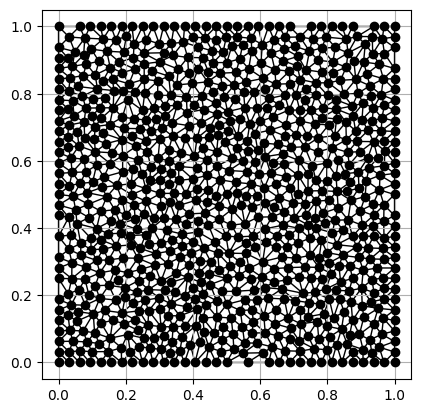

In [7]:
gedim.PlotMesh(mesh)

#### Create Discrete Space FEM and plot the mesh

In [8]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

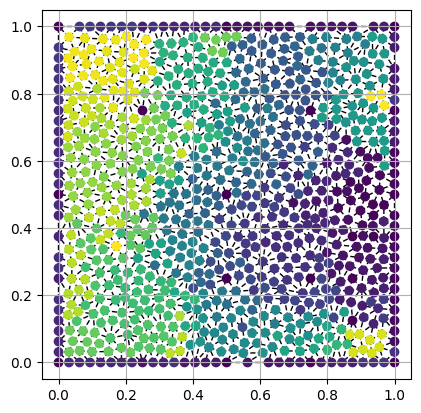

In [9]:
gedim.PlotDofs(mesh, dofs, strongs)

### Newton phase

#### Initial values and Hyperparameters

In [10]:
residual_norm = 1.0  # per farlo entare nel loop
solution_norm = 1.0 #per farlo entarre nel loop
newton_tol = 1.0e-8 #tolleranza relativa
max_iterations = 100 # eventualmente, modifica
num_iteration = 1

In [11]:
# initial guess u
u_k = np.zeros(problemData['NumberDOFs'], order='F') # eventualmente modifica: così potrebbe non convergere
# value on the border (=0) bc homogenous dirichlet
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

In [12]:
np.random.seed(42)  # Imposta il seed per la riproducibilità
mu_set = np.random.uniform(low=0.1, high=1, size=(20, 2))

In [13]:
print("{:<8s} {:<6s} {:>14s} {:>14s} {:>14s} {:>10s} {:>10s} {:>15s}".format(
    "DOFs", "h", "Rel. L2 Err", "Rel. H1 Err", "Rel. Residual", "Iter", "Max Iter", "mu = (μ₀, μ₁)"
))
#Possono stare fuori tutti i temini che non dipendono da termini non lienari (uk) e quindi detro il while loro, e quelli che non dipendono da mu
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Diffusion_a, problemData, lib)
forcingTerm_f_4 = gedim.AssembleForcingTerm(Term_f_4, problemData, lib)
forcingTerm_f_3 = gedim.AssembleForcingTerm(Ones_f_3, problemData, lib)


for mu in mu_set:
    # devo riaggiornare u_k inizale ogni volta, (ma in realtà ha anche senso dargli la soluzione precednte che è buona per avere una convergenza più rapida)
    u_k = np.zeros(problemData['NumberDOFs'], order='F')
    mu_0 = mu[0]
    mu_1 = mu[1]
    u_errorL2 = 5
    u_normL2 = 1
    u_errorH1 = 5
    u_normH1 = 1
    num_iteration = 1
    residual_norm = 10
    solution_norm = 1.0
    
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Reaction_b, Reaction_non_linear_b, u_k, u_strong, problemData, lib)

        forcingTerm_der_f_1 = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative_f_1, Term_non_linear_der_f_1, u_k, u_strong, problemData, lib)
        forcingTerm_f_2 = gedim.AssembleNonLinearForcingTerm(Ones_f_2, Term_non_linear_f_2, u_k, u_strong, problemData, lib)

        # define right and left hand sides
        rhs = -forcingTerm_der_f_1 - mu_0/mu_1 * forcingTerm_f_2 + mu_0/mu_1 * forcingTerm_f_3 + forcingTerm_f_4
        lhs = stiffness + mu_0 * reaction
        # solve linear system to find du
        du = gedim.LUSolver(lhs, \
                rhs, \
                lib)
        #update u_k
        u_k = u_k + du
        
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
    
        """
        u_errorL2 = gedim.ComputeErrorL2(Burger_exactSolution, u_k, u_strong, lib)
        u_errorH1 = gedim.ComputeErrorH1(Burger_exactDerivativeSolution, u_k, u_strong, lib)
        """
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        solution_norm =  u_normL2
        residual_norm =  du_normL2
        #print(residual_norm)
        """relative L2 e H1 errore non hann senso qui perche riferiti alla soluzione esatta"""
        
        print("{:<8d} {:<8.3f} {:<14.6e} {:<14.6e} {:<14.6e} {:<6d} {:<6d}   mu = ({:.3f}, {:.3f})".format(
            problemData['NumberDOFs'],
            problemData['H'],
            u_errorL2 / u_normL2,
            u_errorH1 / u_normH1,
            residual_norm / u_normL2,
            num_iteration,
            max_iterations,
            mu_0,
            mu_1
        ))

        num_iteration += 1

DOFs     h         Rel. L2 Err    Rel. H1 Err  Rel. Residual       Iter   Max Iter   mu = (μ₀, μ₁)
713      0.064    9.657168e+00   1.089002e+00   1.000000e+00   1      100      mu = (0.437, 0.956)
713      0.064    9.667198e+00   1.089903e+00   7.416327e-03   2      100      mu = (0.437, 0.956)
713      0.064    9.667200e+00   1.089903e+00   6.913777e-07   3      100      mu = (0.437, 0.956)
713      0.064    9.667200e+00   1.089903e+00   6.857398e-15   4      100      mu = (0.437, 0.956)
713      0.064    9.706405e+00   1.093420e+00   1.000000e+00   1      100      mu = (0.759, 0.639)
713      0.064    9.713564e+00   1.094068e+00   8.024056e-03   2      100      mu = (0.759, 0.639)
713      0.064    9.713566e+00   1.094068e+00   7.047266e-07   3      100      mu = (0.759, 0.639)
713      0.064    9.713566e+00   1.094068e+00   6.037260e-15   4      100      mu = (0.759, 0.639)
713      0.064    9.627017e+00   1.086295e+00   1.000000e+00   1      100      mu = (0.240, 0.240)
713      0

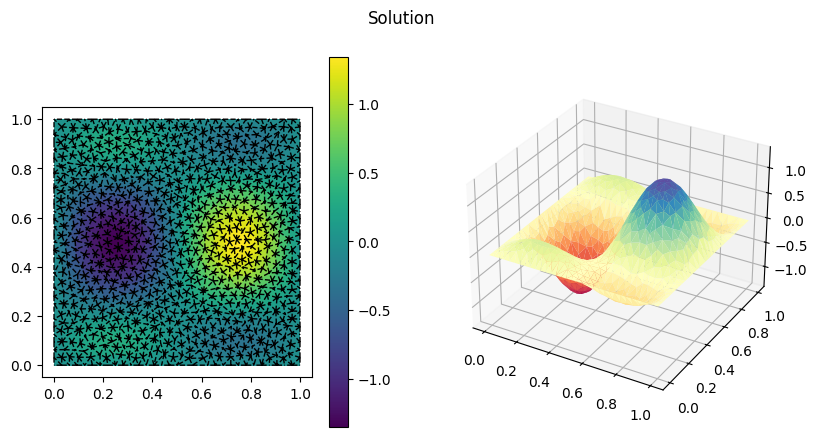

In [14]:
gedim.PlotSolution(mesh, dofs, strongs, u_k, u_strong)
#gedim.ExportSolution(Burger_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)